# 5. Implementing an LSTM model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### The memory and LSTM cell

The intuition behind the Long Short-Term Memory (LSTM) is similar to the Gated Recurrent Unit (GRU) in that it allows the model to selectively choose which information from the previous hidden state to retain and which to discard. However, LSTM uses three gates instead of two to control the flow of information. These gates are the forget gate, input gate, and output gate.

The forget gate, represented by the equation:

$$ f_t = \sigma(W_f * x_t + U_f * h_{t-1} + b_f) $$

is used to decide what information to throw away from the previous cell state, $ c_{t-1} $. The value of $ f_t $ ranges between 0 and 1: a value of 0 means that the new cell state will discard all information from the previous cell state, whereas a value of 1 means that the new cell state will keep all information from the previous cell state.

The input gate, represented by the equation:

$$ i_t = \sigma(W_i * x_t + U_i * h_{t-1} + b_i) $$

is used to decide what new information to store in the current cell state, c_t. It also ranges between 0 and 1: a value of 0 means that no new information will be stored, whereas a value of 1 means that all new information will be stored.

The output gate, represented by the equation:

$$ o_t = \sigma(W_o * x_t + U_o * h_{t-1} + b_o) $$

is used to decide what information to output from the current cell state, c_t. It also ranges between 0 and 1: a value of 0 means that no information will be output, whereas a value of 1 means that all information will be output.

The new cell state, c_t, is then computed by:

$$ c_t = f_t * c_{t-1} + i_t * tanh(W_c * x_t + U_c * h_{t-1} + b_c) $$

The new hidden state, h_t, is computed by:

$$ h_t = o_t * tanh(c_t) $$

Finally, the prediction $ y_t $, supposed to match the ground truth $ x_{t+1} $ is simply defined as:

$$ y_t = o_t * h_t $$

To recap, the diagram of a LSTM cell is shown below.

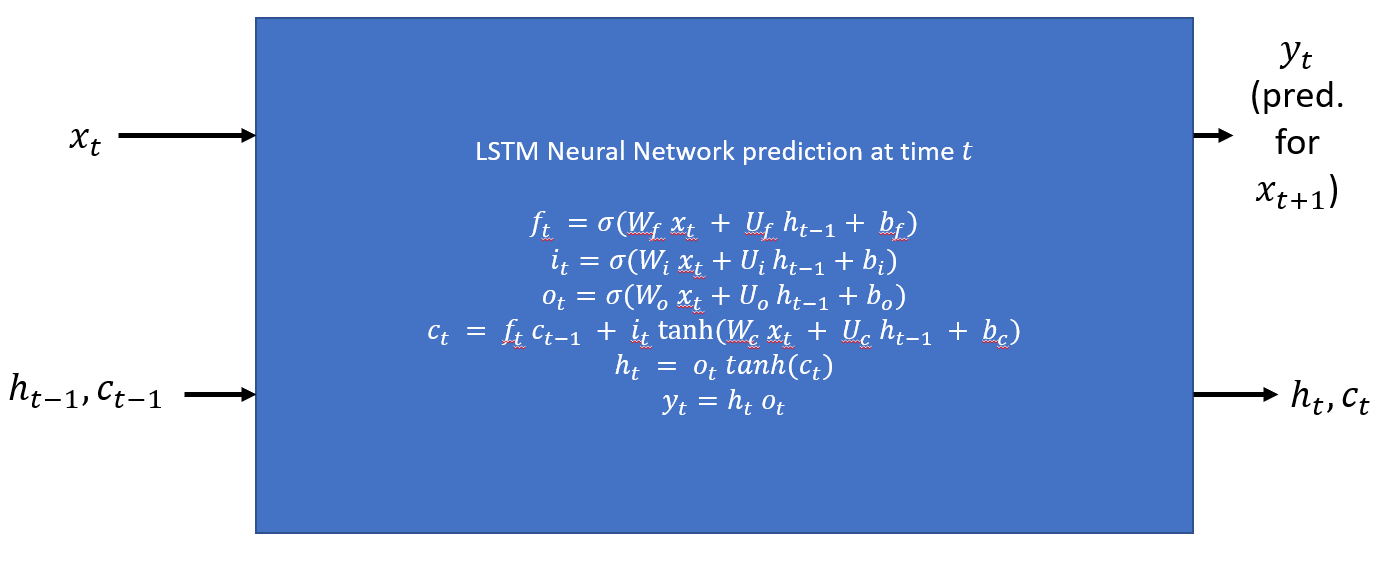

Its implementation, in Numpy, is shown below.

In [3]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Parameters for the forget gate
        self.Wf = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Uf = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bf = torch.nn.Parameter(torch.zeros(hidden_size))

        # Parameters for the input gate
        self.Wi = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Ui = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bi = torch.nn.Parameter(torch.zeros(hidden_size))

        # Parameters for the cell gate
        self.Wc = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Uc = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bc = torch.nn.Parameter(torch.zeros(hidden_size))

        # Parameters for the output gate
        self.Wo = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Uo = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bo = torch.nn.Parameter(torch.zeros(hidden_size))

        # Parameters for the output prediction
        self.V = torch.nn.Parameter(torch.randn(hidden_size, output_size))

    def forward(self, inputs, cell_state, hidden_state):

        # Compute the forget gate
        forget_gate = torch.sigmoid(torch.matmul(inputs, self.Wf) + torch.matmul(hidden_state, self.Uf) + self.bf)

        # Compute the input gate
        input_gate = torch.sigmoid(torch.matmul(inputs, self.Wi) + torch.matmul(hidden_state, self.Ui) + self.bi)

        # Compute the cell gate
        candidate_cell = torch.tanh(torch.matmul(inputs, self.Wc) + torch.matmul(hidden_state, self.Uc) + self.bc)

        # Compute the updated cell state
        cell_state = forget_gate * cell_state + input_gate * candidate_cell

        # Compute the output gate
        output_gate = torch.sigmoid(torch.matmul(inputs, self.Wo) + torch.matmul(hidden_state, self.Uo) + self.bo)

        # Compute the updated hidden state
        hidden_state = output_gate * torch.tanh(cell_state)

        # Compute the output
        output = torch.matmul(hidden_state, self.V)

        return cell_state, hidden_state, output

In [4]:
# Testing out LSTM model
lstm = LSTM(input_size = 1, hidden_size = 4, output_size = 1)
input_data = torch.from_numpy(np.random.randn(1, 1)).float()
h_data = torch.from_numpy(np.random.randn(1, 4)).float()
c_data = torch.from_numpy(np.random.randn(1, 4)).float()
c_next_data, h_next_data, output = lstm.forward(input_data, c_data, h_data)
print("New cell state c size:", c_next_data.shape)
print("New hidden state h size:", h_next_data.shape)
print("Predicted output y size:", output.shape)

New cell state c size: torch.Size([1, 4])
New hidden state h size: torch.Size([1, 4])
Predicted output y size: torch.Size([1, 1])


### Define an LSTM model

This time, using PyTorch. Note that you can specify a *num_layers* in the PyTorch LSTM function.

It simply consists of the number of recurrent layers. e.g., setting num_layers = 2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results.

By default, however, we will stick to only one layer.

In [5]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = 1, batch_first = True)
        
        # Output layer
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state, hidden_state):
        # Forward pass through the LSTM cell
        hidden = cell_state, hidden_state
        output, new_hidden = self.lstm(inputs, hidden)
        cell_state, hidden_state = hidden
        
        # Apply the output layer to the last timestep of the output sequence
        output = self.linear(output)
        
        return cell_state, hidden_state, output

In [6]:
# Define the model parameters
input_size = 1
hidden_size = 4
num_layers = 1
output_size = 1

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTM_pt(
  (lstm): LSTM(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [7]:
# Testing out GRU model
lstm = LSTM_pt(input_size, hidden_size, num_layers, output_size)
input_data = torch.from_numpy(np.random.randn(1, 1)).float()
h_data = torch.from_numpy(np.random.randn(1, 4)).float()
c_data = torch.from_numpy(np.random.randn(1, 4)).float()
c_next_data, h_next_data, output = lstm.forward(input_data, c_data, h_data)
print("New cell state c size:", c_next_data.shape)
print("New hidden state h size:", h_next_data.shape)
print("Predicted output y size:", output.shape)

New cell state c size: torch.Size([1, 4])
New hidden state h size: torch.Size([1, 4])
Predicted output y size: torch.Size([1, 1])


### What's next?

The LSTM model above is ready to be trained as in NB3!

This concludes Week 6.